# Context Generation
Notebook used to showcase and experiment on context generation and contextual learners

#### Import statements
Used to import local functions/modules or external libraries inside the notebook.

In [1]:
from ola2022_project.environment.environment import example_environment, Feature, Step, UserClassParameters
from ola2022_project.simulation.simulation import Simulation, create_n
from ola2022_project.learners import AlphalessLearner
from ola2022_project.algorithms.context_splitting import Context, tree_generation
from ola2022_project.algorithms.multi_armed_bandits import Mab
from ola2022_project.algorithms.reward_estimator import clairvoyant_reward

import numpy as np
import matplotlib.pyplot as plt
import random
import logging
import sys

logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

#### Plotting functions
Functions used to plot data onto a graph for an immediate visualization and analysis.

In [2]:
# Helper function that computes the means for n slices of a given dimension for an array
def mean_slices(array, dim, n):
    ret = []
    for i in range(n):
        ret.append(np.mean(array[i * dim : dim * (i + 1)]))
    return ret

# Plot colors
colors = ['aqua', 'black', 'blue', 'blueviolet', 'burlywood', 'cadetblue', 'chocolate', 
          'coral', 'crimson', 'cyan', 'forestgreen', 'fuchsia', 'gold', 'green', 'hotpink', 
          'indigo', 'lime', 'magenta','navy', 'orange', 'purple', 'red', 'salmon', 
          'silver', 'teal', 'turquoise', 'violet']
n_colors = len(colors)

In [3]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_experiments_days(n_days, rewards, days_step=1, show_mean=True, 
                          cumulate=False, show_markers=True, legend=True,
                          names=None):
    # Encapsulate the rewards in a list if the dimensionality is 1
    plot_rewards = rewards
    if np.ndim(rewards) == 1:
        plot_rewards = [rewards]
    # Calculating and shaping data that is going to be shown on the graph
    days = np.arange(1, n_days + 1, days_step)
    n_exp = len(plot_rewards)
    new_n_days = len(days)
    plot_rewards = \
            np.array(list(map(lambda r: mean_slices(r, days_step, new_n_days), plot_rewards)))
    if(cumulate):
        plot_rewards = np.array(list(map(lambda r: np.cumsum(r), plot_rewards)))
    # Graphical tuning
    marker = "." if show_markers else ""
    plot_colors = \
            random.sample(colors, n_exp) if n_exp <= n_colors else random.choice(colors, n_exp)
    plot_names = ["Experiment {n}" for i in range(len(plot_rewards))]
    if names and len(names) >= len(plot_rewards):
        plot_names = names
    # Creating a new figure and plotting the data onto it
    plt.figure()
    for i, reward in enumerate(plot_rewards):
        plt.plot(days, reward, label=plot_names[i].format(n=i+1), marker=marker, 
                 linestyle='-', color=plot_colors[i])
        if(show_mean):
            mean = [np.mean(plot_rewards[i])] * new_n_days
            plt.plot(days, mean, label="Mean of " + plot_names[i].format(n=i+1), 
                     linestyle='--', color=plot_colors[i])
    # Setting labels and showing the figure
    plt.xlabel("days")
    plt.ylabel("reward")
    if legend:
        plt.legend(loc = "best")
    plt.show()

#### Environment setup
Create the environment reference with customizable parameters.

In [4]:
# Random Number Generator used as a source of randomness by the environment and the simulation
rng = np.random.default_rng(1337)

# Environment separated default parameters
env_classes_parameters=[
        [
            UserClassParameters(10, 0.2, 120),
            UserClassParameters(10, 0.15, 120),
            UserClassParameters(8, 0.5, 300),
            UserClassParameters(7, 0.05, 220),
            UserClassParameters(14, 0.15, 170),
        ],
        [
            UserClassParameters(22, 0.5, 190),
            UserClassParameters(20, 0.1, 210),
            UserClassParameters(16, 0.25, 240),
            UserClassParameters(24, 0.03, 80),
            UserClassParameters(20, 0.05, 360),
        ],
        [
            UserClassParameters(33, 0.4, 180),
            UserClassParameters(25, 0.15, 210),
            UserClassParameters(30, 0.35, 240),
            UserClassParameters(31, 0.05, 300),
            UserClassParameters(36, 0.05, 420),
        ],
    ]

In [5]:
# Creating the environment
env = example_environment(
    total_budget=400,
    class_ratios=[0.3, 0.6, 0.1],
    product_prices=[3, 15, 8, 22, 1],
    classes_parameters=env_classes_parameters,
    lam=0.5,
    max_items=3,
    graph_fully_connected=True,
    graph_zeros_probability=0.5,
    next_products=[(2, 3), (0, 2), (1, 4), (4, 1), (3, 0)],
    random_noise=1e-3,
    graph=np.array(
        [
            [0, 0, 0.7, 0.4, 0],
            [0.3, 0, 0.8, 0, 0],
            [0, 0.2, 0, 0, 0.2],
            [0, 0.9, 0, 0, 0.8],
            [0.05, 0, 0, 0.25, 0],
        ]
    ),
)

#### Running the simulation
Execute the simulation and collect the results.

In [6]:
# Simulation separated default parameters
sim_n_days=7

In [7]:
# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.FIVE,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    features=[Feature("feature_1", None), Feature("feature_2", None)],
    mab_algorithm=Mab.GPTS,
)

In [8]:
simulation.simulate(sim_n_days)
simulation.learner.context_generation(simulation.dataset)
print(simulation.learner.contexts)
simulation.simulate(sim_n_days)
simulation.learner.context_generation(simulation.dataset)
print(simulation.learner.contexts)
simulation.simulate(sim_n_days)
rewards = simulation.rewards
dataset = simulation.dataset

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/7 [00:00<?, ?it/s]

[Context(learner_sim=<ola2022_project.simulation.simulation.Simulation object at 0x7f292fdf6e90>, features=[Feature(name='feature_2', value=0)], nums=2479, exp_prob=0.768205763867369, max_exp_reward=11734.42857142857, weighted_bound=8725.997405925034), Context(learner_sim=<ola2022_project.simulation.simulation.Simulation object at 0x7f292d4172e0>, features=[Feature(name='feature_2', value=1)], nums=573, exp_prob=0.27015558698727016, max_exp_reward=8554.857142857143, weighted_bound=1873.744217725132)]


days:   0%|          | 0/7 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

days:   0%|          | 0/14 [00:00<?, ?it/s]

[Context(learner_sim=<ola2022_project.simulation.simulation.Simulation object at 0x7f292fdf6e90>, features=[Feature(name='feature_2', value=0)], nums=2479, exp_prob=0.768205763867369, max_exp_reward=11734.42857142857, weighted_bound=8725.997405925034), Context(learner_sim=<ola2022_project.simulation.simulation.Simulation object at 0x7f292d4172e0>, features=[Feature(name='feature_2', value=1)], nums=573, exp_prob=0.27015558698727016, max_exp_reward=8554.857142857143, weighted_bound=1873.744217725132)]


days:   0%|          | 0/7 [00:00<?, ?it/s]

#### Plotting the results
Once the simulation has been run, collect the results and display them nicely using plotting functions.

[ 8872.  7437.  7494.  8586.  8805.  6904. 10934.  8899. 11303. 10069.
  9571. 11053.  9401.  9517. 10289. 10818. 10373. 10598. 11126. 10893.
 10358.]


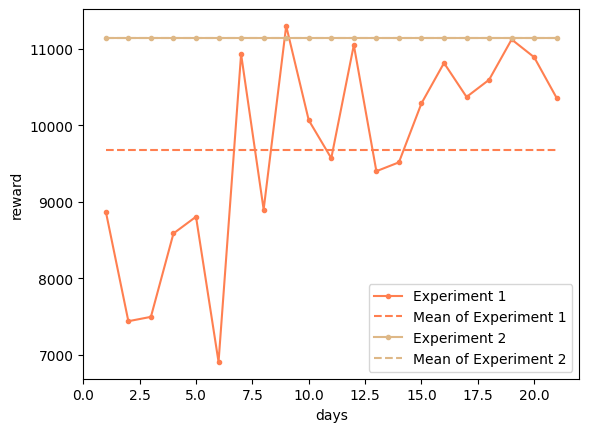

In [9]:
# Plotting the experiment
print(rewards)
clairvoyant = np.full((1, sim_n_days*3), clairvoyant_reward(env, 1000, 400, 20))
plot_experiments_days(sim_n_days*3, [rewards, clairvoyant[0]], days_step=1, 
                      show_mean=True, cumulate=False, show_markers=True, 
                      names=["Experiment {n}"])

#### Context generation

In [10]:
#contexts = tree_generation(
#    simulation,
#    dataset,
#    [Feature("feature_1", None), Feature("feature_2", None)],
#)

In [11]:
print(simulation.rewards)

[ 8872.  7437.  7494.  8586.  8805.  6904. 10934.  8899. 11303. 10069.
  9571. 11053.  9401.  9517. 10289. 10818. 10373. 10598. 11126. 10893.
 10358.]
